In [1]:
import os

import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")


pd.options.mode.chained_assignment = None

import shapely
from shapely.geometry import LineString

from gtfs_data import GTFSData

data_dir = r'Q:\SACSIM23\Network\TransitNetwork\GTFS\SRTD'
os.chdir(data_dir)

gtfs = GTFSData(gtfs_dir=data_dir, data_year=2020)


# update strings to date time format
gtfs.df_stoptimes = gtfs.df_stoptimes.loc[gtfs.df_stoptimes['arrival_time'] < '24:00:00']
gtfs.df_stoptimes = gtfs.df_stoptimes.loc[gtfs.df_stoptimes['departure_time'] < '24:00:00']
gtfs.df_stoptimes[gtfs.f_depart_time] = pd.to_datetime(gtfs.df_stoptimes[gtfs.f_depart_time])
gtfs.df_stoptimes[gtfs.f_arrive_time] = pd.to_datetime(gtfs.df_stoptimes[gtfs.f_arrive_time])

# IMPORTANTLY, probably need to only include stops with arrival and departure times
gtfs.df_stoptimes = gtfs.df_stoptimes.loc[pd.notnull(gtfs.df_stoptimes['arrival_time'])]


In [6]:
gtfs.df_stoptimes.loc[gtfs.df_stoptimes['trip_id'] == 840400].columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'pickup_type', 'drop_off_type'],
      dtype='object')

In [36]:
# for a single trip, get geometry of its trip line shape and geom of stops made on that trip

test_trip_id = 840400 # 't_1063569_b_25331_tn_1'
df_test_trip = gtfs.df_trips.loc[gtfs.df_trips['trip_id'] == test_trip_id]

# create geodataframe of the test trip, with trip data and trip shape
gdf_test_tripshp = df_test_trip.join(gtfs.gdf_lineshps, on='shape_id')
gdf_test_tripshp = gpd.GeoDataFrame(gdf_test_tripshp, geometry='geometry', crs=gtfs.epsg_sacog)

# make point gdf of stop locations along the trip shape
gdf_test_stops = df_test_trip.merge(gtfs.df_stoptimes, on='trip_id') \
                .merge(gtfs.gdf_stops, on='stop_id') \
                [['trip_id', 'stop_id', 'stop_sequence', 'geometry']] \
                .sort_values(by='stop_sequence')
gdf_test_stops = gpd.GeoDataFrame(gdf_test_stops, geometry='geometry') # need this to make geo df instead of regular df


In [14]:
stops_list = gdf_test_stops.stop_sequence.to_list()
stop_pairs = [(stops_list[i], stops_list[i+1]) for i in range(len(stops_list)) if i < len(stops_list)-1]
# stop_pairs

In [79]:

pair = stop_pairs[0]

gdf_pair = gdf_test_stops.loc[gdf_test_stops['stop_sequence'].isin(pair)]
trip_line = gdf_test_tripshp.geometry[0]
coords = gdf_pair.geometry.unary_union

gdf_pair

,trip_id,stop_id,stop_sequence,geometry
0,840400,1184,1,POINT (6770840.747 2009989.278)
1,840400,3301,2,POINT (6770522.910 2009788.961)


In [80]:
# https://shapely.readthedocs.io/en/stable/manual.html#nearest-points

gdf_pair_snapped = gdf_pair
gdf_pair_snapped['geometry'] = gdf_pair_snapped.apply(lambda row: shapely.ops.nearest_points(row['geometry'], trip_line)[1], \
                                                      axis=1)

print(gdf_pair)
print(gdf_pair_snapped)

   trip_id  stop_id  stop_sequence                         geometry
0   840400     1184              1  POINT (6770876.780 2009989.515)
1   840400     3301              2  POINT (6770523.937 2009746.472)
   trip_id  stop_id  stop_sequence                         geometry
0   840400     1184              1  POINT (6770876.780 2009989.515)
1   840400     3301              2  POINT (6770523.937 2009746.472)


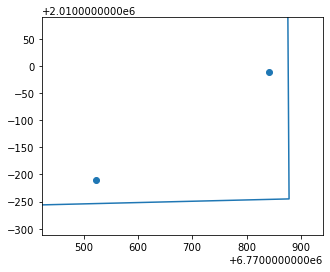

In [88]:
# visually confirm that points snapped to line

def map_it(points_df, line_df):
    test_extent = points_df.geometry.total_bounds
    ax = points_df.plot()
    ax.set_xlim(left=test_extent[0]-100, right=test_extent[2]+100)
    ax.set_ylim(bottom=test_extent[1]-100, top=test_extent[3]+100)
    line_df.plot(ax=ax)
    
map_it(gdf_pair, gdf_test_tripshp)

def split_line_by_points(gdf_points, line_geom):
    from shapely import ops as sops
    
    splitter_points_loose = {}
    for i in range(len(gdf_points)):
        geo = gdf_points.geometry[i]
        lindist = line_geom.project(geo)
        snapcoord = line_geom.interpolate(lindist)
        splitter_points_loose[i] = snapcoord
        
    df_splits = gpd.GeoDataFrame.from_dict(splitter_points_loose, orient='index', geometry=0) \
                .rename(columns={0:'geometry'})
    
    splitter_geo = df_splits.geometry.unary_union
    seg_coll = sops.split(line_geom, splitter_geo)
    
    segments = [seg for seg in seg_coll]
    
    gdf_segments = gpd.GeoDataFrame(
    list(range(len(segments))), geometry=segments)
    
    gdf_segments.columns = ['index', 'geometry']
    
    return gdf_segments

In [89]:
for pair in stop_pairs:
    # pair of stop points
    gdf_pair = gdf_test_stops.loc[gdf_test_stops['stop_sequence'].isin(pair)]
    
    # snap points to be on trip line
    # PROBLEM with snapping: not precise enough for split() function
    # split() will not actually split line at points, even though it should.
    trip_line = gdf_test_tripshp.geometry[0]
    
    gdf_segtest = split_line_by_points(gdf_pair, trip_line)
    print(gdf_segtest)
#     gdf_pair['geometry'] = gdf_pair_snapped.apply(lambda row: shapely.ops.nearest_points(row['geometry'], trip_line)[1], \
#                                                       axis=1)
#     gdf_pair['geometry'].unary_union
    
#     print(splitter_coords)
#     map_it(gdf_pair, gdf_test_tripshp)

#     # snap and split coords on line
#     # returns GeometryCollection
#     split_line = shapely.ops.split(trip_line, splitter_coords)

#     # transform Geometry Collection to GeoDataFrame
#     segments = [feature for feature in split_line]
#     print(segments)

#     gdf_segments = gpd.GeoDataFrame(
#         list(range(len(segments))), geometry=segments)
    
#     gdf_segments.columns = ['index', 'geometry']
    
    # get the line segment that corresponse to the portion between the two stops, not before or after them
    line_seg = gdf_segments.loc[gdf_segments.index == 1].set_crs(epsg=gtfs.epsg_sacog)

    # add trip id to segment
    line_seg['trip_id'] = test_trip_id

    # select the 2 stops closest to the segment
    gdf_pair['dist_to_line'] = gdf_pair.distance(line_seg)
    gdf_pair = gdf_pair.sort_values(by=['dist_to_line'])[:2]
    gdf_pair = gdf_pair.sort_values(by=['stop_sequence'])

    # start dict of segment data
    seg_data = {}

    # join segment table to stop time table
    jn = gdf_pair.merge(gtfs.df_stoptimes, on=['trip_id', 'stop_id', 'stop_sequence'], \
                        suffixes=('', 'y'))

    stop1_data = jn.iloc[0]
    stop2_data = jn.iloc[1]

    seg_data['begin_stop'] = stop1_data['stop_id']
    seg_data['end_stop'] = stop2_data['stop_id']
    seg_data['seg_len_mi'] = line_seg.length.mean() / 5280
    seg_data['seg_start_time'] = stop1_data['departure_time']
    seg_data['seg_end_time'] = stop2_data['arrival_time']
    seg_data['duration_mins'] = (seg_data['seg_end_time'] - seg_data['seg_start_time']).seconds / 60
    seg_data['speed_mph'] = -1 if seg_data['duration_mins'] == 0 else \
        seg_data['seg_len_mi'] / (seg_data['duration_mins'] / 60)
    # seg_data['geometry'] = line_seg['geometry'][1]
    
    # segment_data.append(seg_data)

   index                                           geometry
0      0  LINESTRING (6770873.931 2010334.801, 6770874.5...


KeyError: 0

In [85]:
splitter_coords.wkt
[i for i in shapely.ops.split(trip_line, splitter_coords)]

gdf_pair.distance(trip_line)

# gpd.GeoSeries(gdf_pair_snapped.apply(lambda row: shapely.ops.nearest_points(row['geometry'], trip_line)[1], \
#                                                       axis=1), crs=2226).unary_union

1    6.186572e-11
2             NaN
dtype: float64

In [27]:
segment_data

test_gdf = gpd.GeoDataFrame(segment_data)
test_gdf # [['begin_stop', 'end_stop']]

,begin_stop,end_stop,seg_len_mi,seg_start_time,seg_end_time,duration_mins,speed_mph
0,1184,3301,NaN,2023-01-15 21:44:00,2023-01-15 21:44:00,0.0,-1.000000
1,3301,1187,NaN,2023-01-15 21:44:00,2023-01-15 21:45:00,1.0,NaN
2,1187,1188,NaN,2023-01-15 21:45:00,2023-01-15 21:45:00,0.0,-1.000000
3,1188,1189,7.361579,2023-01-15 21:45:00,2023-01-15 21:46:00,1.0,441.694760
4,1189,1190,7.361579,2023-01-15 21:46:00,2023-01-15 21:47:00,1.0,441.694760
5,1190,1191,6.926481,2023-01-15 21:47:00,2023-01-15 21:48:00,1.0,415.588860
6,1191,1192,6.926481,2023-01-15 21:48:00,2023-01-15 21:48:00,0.0,-1.000000
7,1192,1193,6.579098,2023-01-15 21:48:00,2023-01-15 21:49:00,1.0,394.745898
8,1193,1195,6.579098,2023-01-15 21:49:00,2023-01-15 21:50:00,1.0,394.745898
9,1195,1196,5.842126,2023-01-15 21:50:00,2023-01-15 21:51:00,1.0,350.527584


In [112]:

test_gdf['seg_start_time'] = test_gdf['seg_start_time'].astype('str')
test_gdf['seg_end_time'] = test_gdf['seg_end_time'].astype('str')
print(test_gdf.info())
test_outfile = r'C:\Users\dconly\Desktop\Temporary\geopandas-v-sedf\trip_segs.shp'
test_gdf.to_file(test_outfile)

KeyError: 'seg_start_time'

In [132]:
gdf_test_stops.head()

,trip_id,stop_id,stop_sequence,geometry
0,840400,1184,1,POINT (6770840.747 2009989.278)
1,840400,3301,2,POINT (6770522.910 2009788.961)
2,840400,1187,3,POINT (6769355.713 2009772.670)
3,840400,1188,4,POINT (6767905.579 2009723.589)
4,840400,1189,5,POINT (6766646.877 2009689.941)


<AxesSubplot:>

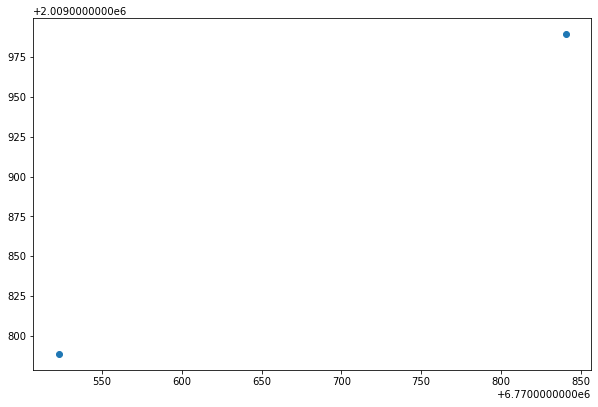

In [9]:
# ax = gdf_segments.loc[gdf_segments.index == 0].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax = gdf_segments.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
df_nearest_seg = gdf_test_stops # gdf_test_stops.loc[gdf_test_stops['distance'] < 100]
gdf_pair.plot(ax=ax)